# Определение перспективного тарифа для телеком компании.

Итак. Есть «Мегалайн» — федеральный оператор сотовой связи. «Мегалайн» предлагает клиентам два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Наша задача сделать предварительный анализ тарифов на небольшой выборке клиентов. В нашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше. 

#### План работы над проектом :

   1. [Обзор и загрузка данных.](#Step_1)
   2. [Подготовка данных:](#Step_2)
       * [Изменение типов, округление и удаление данных.](#Step_2_1)
       * [Расчёт основных метрик тарифов: количество звонков, минут,сообщений, трафика и размер выручки.](#Step_2_2)
   3. [Анализ данных:](#Step_3)    
       * [Расчёт ключевых метрик по месяцам для обоих тарифов.](#Step_3_1)
       * [Расчёт среднего, дисперсии и стандартного отклонения для каждого тарифа по ключевым метрикам.](#Step_3_2)
       * [Построение гистограмм основных метрик тарифов smart и ultra.](#Step_3_3)
   4. [Проверка гипотезы:](#Step_4)
       * [ Проверка гипотезу о том, что средняя выручка пользователей тарифов «Ультра» и «Смарт» различается.](#Step_4_1)
       * [Проверка гипотезы о том, что средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.](#Step_4_2)
   5. [Общий вывод.](#Step_5)

### Шаг 1. Обзор и загрузка данных. <a id="Step_1"></a>

Первое, что нам необходимо сделать - это загрузить необходимые библиотеки.

In [1]:
import pandas as pd
import math
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt

После того, как необходимые библиотеки загружены, приступим к непосредственной работе с имеющимися данными.

In [2]:
data_users = pd.read_csv('/datasets/users.csv', sep=',')
data_calls = pd.read_csv('/datasets/calls.csv', sep=',')
data_internet = pd.read_csv('/datasets/internet.csv', sep=',')
data_messages = pd.read_csv('/datasets/messages.csv', sep=',')
data_tariffs = pd.read_csv('/datasets/tariffs.csv', sep=',')

В первом приближении имеем пять файлов, которые несут нам следующую информацию: 

- `/datasets/users.csv` - основная информация о клиентах
- `/datasets/calls.csv` - информация о звонках, сделанных клиентами 
- `/datasets/internet.csv` - информация об использованном клиентами интернет-трафике
- `/datasets/messages.csv` - информация об отправленных сообщениях
- `/datasets/tariffs.csv` - и, наконец, информация о самих тарифах, которыми пользуются клиенты

Стоит ещё раз отметить, что все данные приведены за 2018 год для случайно выбранных 500 человек. 

Данные загружены. Датафреймам даны соответствующее содержанию имена. Рассмотрим теперь каждый из них более подробно. Начнём с общей информации о клиентах `data_users`. Для детального описания и анализа будем использовать сразу три инструмента: 

- `display()`
- `info()`
- `describe()`

In [3]:
display(data_users)
data_users.info()
data_users.describe()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
...,...,...,...,...,...,...,...,...
495,1495,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra
496,1496,36,NaN,Вологда,Трифон,Блохин,2018-01-27,smart
497,1497,32,NaN,Челябинск,Каролина,Агеева,2018-10-09,smart
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,user_id,age
count,500.000000,500.00000
mean,1249.500000,46.58800
std,144.481833,16.66763
min,1000.000000,18.00000
25%,1124.750000,32.00000
50%,1249.500000,46.00000
75%,1374.250000,62.00000
max,1499.000000,75.00000


Расмотрим теперь столбцы фрейма `data_users`:

1. `user_id` - id каждого клиента. Пропущенных значений нет. Начинается с 1000 заканчивается 1499, что полностью укладывается в исходную парадигму о 500 случайных пользователях. Статистические показатели, полученные методом `describe()`, какой-то особой ценности для анализа нам не несут, просто в силу специфики самой информации, содержащейся в столбце.
2. `age` - возраст клиентов. Пропущенных значений также нет. Говорить о каких-либо аномалиях на фоне статстических показателей не приходится. 
3. `churn_date` - дата прекращения пользования тарифом. Единственный столбец в этой таблице, где есть пропущенные значения. Пропуски в данной ситуации говорят нам о том, что подавляющее большинство клиентов продолжили пользоваться своим тарифов и лишь 38 тариф изменили. Данный столбец напрямую в расчётах для решения поставленных задач не участвует, поэтому и делать что-то с этими пропусками большого смысла нет. 
4. `city` - города проживания клиентов. Все значения на месте. 
5. `first_name`, `last_name` - имена и фамилии клиентов. Пропусков нет, но для решения поставленной задачи столбцы имеют нулевую значимость. 
6. `reg_data` - дата регистрации клиентов. Пропусков нет. В процессе предобработки нужно будет изменить тип данных столбца на `datetime`.
7. `tariff` - тариф каждого из клиентов. Пропусков нет. 

Далее рассмотрим информацию о звонках клиентов, содержащуюся в фрейме `data_calls`.

In [4]:
display(data_calls)
data_calls.info()
data_calls.describe()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
...,...,...,...,...
202602,1499_215,2018-12-26,0.76,1499
202603,1499_216,2018-10-18,18.83,1499
202604,1499_217,2018-11-10,10.81,1499
202605,1499_218,2018-10-06,4.27,1499


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


,duration,user_id
count,202607.000000,202607.000000
mean,6.755887,1253.940619
std,5.843365,144.722751
min,0.000000,1000.000000
25%,1.300000,1126.000000
50%,6.000000,1260.000000
75%,10.700000,1379.000000
max,38.000000,1499.000000


Общим для всех столбцов здесь является отсутствие пропусков. Далее проанализируем каждый столбец отдельно. 

1. `id` - уникальный id каждого звонка. 
2. `call_date` - дата звонка. Необходимо будет изменирь формат на `datetime`
3. `duration` - продолжительность каждого звонка. Стоит обратить внимание на нулевые значения продолжительности разговора. Подобные данные могут возникать в первую очередь из-за звонков, на которые по тем или иным причинам не ответили (просто не взяли трубку, сбой работы сети, абонент вне зоны доступа и т.д.). В процессе подготовки данных необходимо будет нулевые значения просто удалить, так как какой-либо полезной нагрузки они не несут, но, возможно, пусть и незначительно, в состоянии искажать статистические показатели при расчётах.
Также, необходимо будет округлить значения столбца до целых чисел в большую сторону, так как оплату за минуту оператор берёт даже в случае использование только одной секунды из неё.

4. `user_id` - id клиента.

Датафрейм с данными об использовании клиентами интернет трафика. 

In [5]:
display(data_internet)
data_internet.info()
data_internet.describe()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000
...,...,...,...,...,...
149391,149391,1499_152,318.90,2018-10-03,1499
149392,149392,1499_153,490.13,2018-12-14,1499
149393,149393,1499_154,0.00,2018-10-27,1499
149394,149394,1499_155,1246.32,2018-11-26,1499


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


,Unnamed: 0,mb_used,user_id
count,149396.000000,149396.000000,149396.000000
mean,74697.500000,370.192426,1252.099842
std,43127.054745,278.300951,144.050823
min,0.000000,0.000000,1000.000000
25%,37348.750000,138.187500,1130.000000
50%,74697.500000,348.015000,1251.000000
75%,112046.250000,559.552500,1380.000000
max,149395.000000,1724.830000,1499.000000


Также проанализируем каждый столбец. 

1. `Unnamed: 0` - столбец дублирующий индекс. Два индекса нам совершенно ни к чему. 
2. `id` - уникальный номер каждой интернет - сессии. 
3. `mb_used` - количество трафика потраченного за сессию. Здесь присутствуют нулевые значения и причина их появление, видимо, схожа с аналогичной ситуацией со звонками: клиент попробовал выйти в интернет, но что-то пошло не так (неисправность устройства, сбой в сети, плохое покрытие и т.д.), соединение установить не удалось.
Как и в случае со звонками от таких сессий хорошего ждать не приходится, а вот проблем они, теоритически, создать могут. Поэтому все нулевые значения использованного трафика необходимо будет исключить. Также, как и в случае со звонками, для корректности дальнейших расчётов, округлим значения столбца до целых чисел в большую сторону.
4. `session_date` - дата выхода в интернет. Заменить тип данных на `datetime`.
5. `user_id` - id клиентов

Датафрейм с данными о сообщениях `data_messages`.

In [6]:
display(data_messages)
data_messages.info()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
...,...,...,...
123031,1499_179,2018-12-12,1499
123032,1499_180,2018-09-28,1499
123033,1499_181,2018-09-27,1499
123034,1499_182,2018-11-15,1499


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


Пропущенных значений нет, информация в столбцах следующая:

 1. `id` и `user_id` - уникальный id сообщения и пользователя.
 2. `message_date` - дата отправки сообщения. 

И заключительный датафрейм - данные по тарифам `data_tariffs`.

In [7]:
display(data_tariffs.T)

,0,1
messages_included,50,1000
mb_per_month_included,15360,30720
minutes_included,500,3000
rub_monthly_fee,550,1950
rub_per_gb,200,150
rub_per_message,3,1
rub_per_minute,3,1
tariff_name,smart,ultra


Все данные на месте, а сказать, что в принципе понятно было и из задания, можно следующее: перед нами две
классические модели тарифов.  `smart` - дешевле абонентская плата, но относительно небольшой ресурс по основным услугам, выход за пределы предоставленного объёма которых обойдётся ещё и дороже, чем у конкурирующего тарифа. `ultra` - тариф из разряда почти-всё-включено) Объёмы услуг - выше, выход за пределы этих объёмов - дешевле, но и абонентская плата существенно отличается в большую сторону. 
Посмотрим, за каким из тарифов в результате окажется преимущество.

#### Результат выполнения 1 шага загрузки и обзора данных:
*Данные успешно загружены, проведён их первичный анализ, определены необходимые действия для последующей корректной подготовки и предобработки имеющейся информации.*

### Шаг 2. Подготовка данных. <a id="Step_2"></a>

*2.1. Изменение типов, округление и удаление данных.* <a id="Step_2_1"></a>

Для фрейма `data_users` изменим тип данных столбца `reg_data` на `datetime`.

In [8]:
data_users['reg_date'] = pd.to_datetime(data_users['reg_date'], format='%Y-%m-%dT')

Для фрейма `data_calls`:
 1. Изменим тип данных столбца `call_date` на `date_time`;
 2. Удалим все строки с длительностью звонка равной 0.
 3. Округлим значения столбца `duration` до целых числе в большую сторону.

In [9]:
data_calls['call_date'] = pd.to_datetime(data_calls['call_date'], format='%Y-%m-%dT')

In [10]:
data_calls = data_calls.query('duration > 0')

In [11]:
data_calls['duration'] = data_calls['duration'].apply(math.ceil)

Для фрейма `data_internet`: 

1. Заменим тип данных для столбца `session_date` на `datetime`;
2. Удалим столбец Unnamed: 0 ; 
3. Удалим все строки фрейма, для которых объём трафика, потраченного за интернет-сессию равен 0.
4. Округлим значения столбца `mb_used` до целых числе в большую сторону.

In [12]:
data_internet['session_date'] = pd.to_datetime(data_internet['session_date']
                                               , format='%Y-%m-%dT')

In [13]:
del data_internet['Unnamed: 0']

In [14]:
data_internet = data_internet.query('mb_used > 0')

In [15]:
data_internet['mb_used'] = data_internet['mb_used'].apply(math.ceil)

Для фрейма `data_messages` изменим тип данных столбца `messages_data` на `datetime`.

In [16]:
data_messages['message_date'] = pd.to_datetime(data_messages['message_date']
                                               , format='%Y-%m-%dT')

*2.2. Расчёт основных метрик тарифов: количество звонков, минут,сообщений, трафика и размер выручки.* <a id="Step_2_2"></a>

Для дальнейших расчётов добавим в соответствующие таблицы столбец с месяцами.

In [17]:
data_calls['month_of_calls'] = pd.DatetimeIndex(data_calls['call_date']).month
data_internet['month_of_session'] = pd.DatetimeIndex(data_internet['session_date']).month
data_messages['month_of_message'] = pd.DatetimeIndex(data_messages['message_date']).month

Посчитаем количество звонков и минут для каждого пользователя по месяцам.

In [18]:
pivot_data = (data_calls
              .groupby(['user_id','month_of_calls'])
              .agg({'duration' : ['count', 'sum']})
              .reset_index())

pivot_data.columns = pivot_data.columns.droplevel(1)
pivot_data.columns.values[1] = 'month'
pivot_data.columns.values[2] = 'count_of_calls'
pivot_data.columns.values[3] = 'count_of_minutes'

display(pivot_data)

,user_id,month,count_of_calls,count_of_minutes
0,1000,5,17,159
1,1000,6,28,172
2,1000,7,41,340
3,1000,8,42,408
4,1000,9,46,466
...,...,...,...,...
3163,1498,10,30,247
3164,1499,9,8,70
3165,1499,10,44,449
3166,1499,11,62,612


Получим количество отправленных сообщений для каждого пользователя.

In [19]:
group_data_messages = (data_messages
              .groupby(['user_id','month_of_message'])['id']
              .count()
              .reset_index())

group_data_messages.rename(columns={'id': 'count_of_messages', 'month_of_message': 'month'}
                  , inplace=True)

display(group_data_messages)

,user_id,month,count_of_messages
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57
...,...,...,...
2712,1498,10,42
2713,1499,9,11
2714,1499,10,48
2715,1499,11,59


Посчитаем объём израсходанного интернет-трафика для каждого пользователя по месяцам.

In [20]:
group_data_internet = (data_internet
              .groupby(['user_id','month_of_session'])['mb_used']
              .sum()
              .reset_index())

group_data_internet.rename(columns={'mb_used': 'count_of_mb', 'month_of_session' : 'month'}
                           , inplace=True)

display(group_data_internet)

,user_id,month,count_of_mb
0,1000,5,2256
1,1000,6,23257
2,1000,7,14016
3,1000,8,14070
4,1000,9,14581
...,...,...,...
3196,1498,10,20604
3197,1499,9,1848
3198,1499,10,17809
3199,1499,11,17984


Добавим к нашей сводной таблице информацию о сообщениях и интернет-трафике. 

In [21]:
pivot_data = pivot_data.merge(group_data_messages, how='outer', on=['user_id','month'])
pivot_data = pivot_data.merge(group_data_internet, how='outer', on=['user_id','month'])

In [22]:
pivot_data = pivot_data.sort_values( by = ['user_id', 'month'])
display(pivot_data)
pivot_data.info()

,user_id,month,count_of_calls,count_of_minutes,count_of_messages,count_of_mb
0,1000,5,17.0,159.0,22.0,2256.0
1,1000,6,28.0,172.0,60.0,23257.0
2,1000,7,41.0,340.0,75.0,14016.0
3,1000,8,42.0,408.0,81.0,14070.0
4,1000,9,46.0,466.0,57.0,14581.0
...,...,...,...,...,...,...
3163,1498,10,30.0,247.0,42.0,20604.0
3164,1499,9,8.0,70.0,11.0,1848.0
3165,1499,10,44.0,449.0,48.0,17809.0
3166,1499,11,62.0,612.0,59.0,17984.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3167
Data columns (total 6 columns):
user_id              3214 non-null int64
month                3214 non-null int64
count_of_calls       3168 non-null float64
count_of_minutes     3168 non-null float64
count_of_messages    2717 non-null float64
count_of_mb          3201 non-null float64
dtypes: float64(4), int64(2)
memory usage: 175.8 KB


В результате объединения данных образовались значения NaN: кто-то, скажем, много звонит и сидит в интернете, но не отправил не одного смс за этот же период. Или любая другая комбинация в этом же духе. 

Для дальнейших расчётов заменим значения NaN на 0.

In [23]:
pivot_data['count_of_calls']= pivot_data['count_of_calls'].fillna(0)
pivot_data['count_of_minutes']= pivot_data['count_of_minutes'].fillna(0)
pivot_data['count_of_messages']= pivot_data['count_of_messages'].fillna(0)
pivot_data['count_of_mb']= pivot_data['count_of_mb'].fillna(0)

Добавим тарифный план в сводную таблицу.

In [24]:
pivot_data = pivot_data.merge(data_users.loc[:,['user_id','tariff']]
                              ,how='left'
                              ,on=['user_id'])

Напишем и применим функцию для расчёта выручки, добавив соответствующий столбец в сводную таблицу.

In [25]:
def calculation_of_revenue (row):
    
    count_of_minutes = row['count_of_minutes']
    count_of_messages = row['count_of_messages']
    count_of_mb = row['count_of_mb']
    tariff = row['tariff']
    
    if tariff == "smart":
        revenue = 550
        
        if count_of_minutes > 500:
            revenue += (count_of_minutes - 500) * 3
            
        if count_of_messages > 50: 
            revenue += (count_of_messages - 50) * 3
                
        if count_of_mb > 15360: 
            revenue += math.ceil((count_of_mb - 15360)/1000) * 200
                    
        return revenue
            
    elif tariff == "ultra":
        revenue = 1950
        
        if count_of_minutes > 3000:
            revenue += (count_of_minutes - 3000)
            
        if count_of_messages > 1000: 
            revenue += (count_of_messages - 1000)
                
        if count_of_mb > 30720: 
            revenue += math.ceil((count_of_mb - 30720)/1000) * 150
                    
                
    return revenue

pivot_data['revenue'] = pivot_data.apply(calculation_of_revenue, axis = 1)

#### Результат выполнения 2 шага подготовки данных:
*Все необходимые изменения, обозначенные в шаге 1, успешно произведены: лишние данные убрали, тип данных изменили, значения округлили. Помимо этого рассчитали все ключевые метрики и добавили их в сводную таблицу `pivot_data` *

### Шаг 3. Анализ данных. <a id="Step_3"></a>

*3.1. Посчитаем сколько минут разговора, сообщений и интернет-трафика требуется пользователям каждый месяц, а также, сколько в итоге это приносит компании.* <a id="Step_3_1"></a>

In [26]:
display(pivot_data)

,user_id,month,count_of_calls,count_of_minutes,count_of_messages,count_of_mb,tariff,revenue
0,1000,5,17.0,159.0,22.0,2256.0,ultra,1950.0
1,1000,6,28.0,172.0,60.0,23257.0,ultra,1950.0
2,1000,7,41.0,340.0,75.0,14016.0,ultra,1950.0
3,1000,8,42.0,408.0,81.0,14070.0,ultra,1950.0
4,1000,9,46.0,466.0,57.0,14581.0,ultra,1950.0
...,...,...,...,...,...,...,...,...
3209,1498,10,30.0,247.0,42.0,20604.0,smart,1750.0
3210,1499,9,8.0,70.0,11.0,1848.0,smart,550.0
3211,1499,10,44.0,449.0,48.0,17809.0,smart,1150.0
3212,1499,11,62.0,612.0,59.0,17984.0,smart,1513.0


Пользователи тарифа smart.

In [27]:
pivot_data_smart = (pivot_data
        .query('tariff == "smart"')
        .groupby(['tariff','month'])['count_of_minutes'
                                     ,'count_of_messages'
                                     ,'count_of_mb'
                                     ,'revenue']
        .sum()
        .reset_index())

display(pivot_data_smart)

,tariff,month,count_of_minutes,count_of_messages,count_of_mb,revenue
0,smart,1,6931.0,620.0,289831.0,24725.0
1,smart,2,17324.0,1397.0,673461.0,48201.0
2,smart,3,30034.0,2453.0,1164537.0,90676.0
3,smart,4,41119.0,3443.0,1509702.0,108666.0
4,smart,5,54618.0,4762.0,2231353.0,171449.0
5,smart,6,64885.0,5478.0,2593622.0,200059.0
6,smart,7,82079.0,6784.0,3168466.0,250014.0
7,smart,8,99045.0,7905.0,3908561.0,314340.0
8,smart,9,111439.0,8746.0,4244377.0,329386.0
9,smart,10,125284.0,9927.0,4932898.0,405067.0


Пользователи тарифа ultra.

In [28]:
pivot_data_ultra = (pivot_data
        .query('tariff == "ultra"')
        .groupby(['tariff','month'])['count_of_minutes'
                                     ,'count_of_messages'
                                     ,'count_of_mb'
                                     ,'revenue']
        .sum()
        .reset_index())

display(pivot_data_ultra)

,tariff,month,count_of_minutes,count_of_messages,count_of_mb,revenue
0,ultra,1,3853.0,304.0,118382.0,17550.0
1,ultra,2,7131.0,527.0,282887.0,47400.0
2,ultra,3,18117.0,1195.0,649423.0,74550.0
3,ultra,4,25191.0,1736.0,926409.0,110100.0
4,ultra,5,34192.0,2536.0,1298540.0,138300.0
5,ultra,6,40295.0,3505.0,1591148.0,171450.0
6,ultra,7,49667.0,4536.0,1866833.0,193500.0
7,ultra,8,54653.0,5183.0,2096565.0,223200.0
8,ultra,9,62036.0,6013.0,2210554.0,232950.0
9,ultra,10,68644.0,7187.0,2467856.0,254550.0


Для лучшего анализа полученных данных посчитаем количество пользователей тарифа `smart` и `ultra`, доступное нам из загруженной выборки.  

In [29]:
display(data_users['tariff'].value_counts().reset_index())

,index,tariff
0,smart,351
1,ultra,149


Из сводных таблиц для каждого из тарифов отчётливо видно, что по всем ключевым метрикам лидирует тариф `smart`, число пользователей которого, исходя из данных нашей выборки, почти в 2,5 раза больше, чем полизователей тарифа `ultra`.

*3.2. Вычислим среднее, дисперсию и стандартное отклонение для каждого тарифа по ключевым метрикам.* <a id="Step_3_2"></a>

Для тарифа `smart`.

In [30]:
statistical_indicators = (pivot_data_smart
              .groupby(['tariff'])
              .agg({'count_of_minutes' : ['mean', 'var','std']
                    ,'count_of_messages' : ['mean', 'var','std']
                    ,'count_of_mb' : ['mean', 'var','std']
                    ,'revenue' : ['mean', 'var','std']})
              .round()
              .reset_index()
              .T)

statistical_indicators.columns = ['']
display(statistical_indicators)

tariff                        smart
count_of_minutes  mean        77631
                  var   2.49128e+09
                  std         49913
count_of_messages mean         6201
                  var   1.43716e+07
                  std          3791
count_of_mb       mean  3.01457e+06
                  var   3.67529e+12
                  std   1.91711e+06
revenue           mean       242479
                  var   2.67623e+10
                  std        163592

Для тарифа `ultra`.

In [31]:
statistical_indicators_2 = (pivot_data_ultra
              .groupby(['tariff'])
              .agg({'count_of_minutes' : ['mean', 'var','std']
                    ,'count_of_messages' : ['mean', 'var','std']
                    ,'count_of_mb' : ['mean', 'var','std']
                    ,'revenue' : ['mean', 'var','std']})
              .round()
              .reset_index()
              .T)

statistical_indicators_2.columns = ['']

display(statistical_indicators_2)

tariff                        ultra
count_of_minutes  mean        43227
                  var   6.78652e+08
                  std         26051
count_of_messages mean         4052
                  var   8.05736e+06
                  std          2839
count_of_mb       mean  1.59955e+06
                  var   9.07599e+11
                  std        952680
revenue           mean       170162
                  var    8.6395e+09
                  std         92949

Для наглядноси объединим ключевые метрики обоих тарифов в общую таблицу.

In [32]:
pd.concat([statistical_indicators,statistical_indicators_2], axis=1)

tariff                        smart        ultra
count_of_minutes  mean        77631        43227
                  var   2.49128e+09  6.78652e+08
                  std         49913        26051
count_of_messages mean         6201         4052
                  var   1.43716e+07  8.05736e+06
                  std          3791         2839
count_of_mb       mean  3.01457e+06  1.59955e+06
                  var   3.67529e+12  9.07599e+11
                  std   1.91711e+06       952680
revenue           mean       242479       170162
                  var   2.67623e+10   8.6395e+09
                  std        163592        92949

Логичным продолжением наших предыдущих сводных таблиц по тарифам является сводная таблица статистических показателей. Логичным в первую очередь по тому, что подкрепляет наши первоначальные выводы относительно полученных данных. Среднее всех метрик у тарифа `smart` выше, также как и дисперсия со стандартным отклонением, характеризующие разброс значений изучаемой метрики. Анализ этих показателей, даёт нам основанием полагать, что в рамках тарифа `smart` удаётся не только генерировать больший поток клиентов и как следствие большие трафик и выручку, но сам этот процесс носит более динамичный характер, чем в случае с тарифом `ultra`.

*3.3. Построим гистограммы основных метрик тарифов `smart` и `ultra`.* <a id="Step_3_3"></a>

Построим гистограммы на основе общей сводной таблицы для тарифов `pivot_table`.
Напишем соответствующую нашей задаче функцию.

При написании функции автоматического построения гистограмм возникла следующая ситуация. Для того, чтобы задать границы построения гистограммы мы пользуемся диаграммой размаха. В данном случае этот же принцип использован не в графическом виде, а как расчёт необходимых показателей `Q1`, `Q3`, `IQR` и т.д. Но для метрики `revenue` тарифа `ultra` квартили `Q1` и `Q3` оказались равны, что приводит нас к нулевому интерквартильному размаху.

Чтобы границы построения гистограммы были заданы корректно даже в этом случае, я воспользовался альтернативным способом расчёта интерквартильного размаха (с помощью пяти- и девяностопятипроцентных персентлей: `Q_5` и `Q_95` соотвественно), изложенного в разделе `"Диаграмма размаха"` данной [статьи](https://habr.com/ru/post/267123/).

Также, зная, что из двух практически идентичных блоков кода функции для построения первой и второй диаграммы соответственно, использование альтернативной методики расчёта интерквартильного размаха нам понадобится только для второй диаграммы и как следствие только для второго блока, я, тем не менее, добавил альтернативный вариант и в первый блок, с целью большей универсализации самой функции.

In [33]:
def hist_of_data_2 (data_1, data_2): 
    for column in data_1:
        
        # Первый блок для построения первой гистограммы
        
        Q1 = data_1[column].quantile(0.25)
        Q3 = data_1[column].quantile(0.75)
        Q_5 = data_1[column].quantile(0.05)
        Q_95 = data_1[column].quantile(0.95)
        IQR = Q3 - Q1
        IQR_MIN = Q1 - Q_5   # аналог 1,5 * IQR со стороны минимума
        IQR_MAX = Q_95 - Q3  # аналог 1,5 * IQR со стороны максимума
        MIN = data_1[column].min()
        MAX = data_1[column].max()
        
        if Q1 == Q3: 
            
            # Альтернативный расчёт границ построения диграммы
            # Здесь только 2 варианта развития событий, так как в силу самого условия альтернативного
            # расчёта (Q1 == Q3), нижняя граница всегда будет равна минимальному значению метрики (MIN).
            # Следовательной расчёт IQR_MIN и последующая его записи носят исключительно показательный 
            # характер, для большей наглядности. Технически можно было бы обойтись и без них.
            
            if Q1 - IQR_MIN <= MIN and Q3 + IQR_MAX < MAX :
                data_2[column].hist(bins = 50, range = (MIN, Q3 + IQR_MAX))
                plt.title(column)
                plt.show()
                
            else:
                data_2[column].hist(bins = 50, range = (MIN, MAX))
                plt.title(column)
                plt.show()
                
        # Далее идёт стандартный расчёт параметров для определения границ первой гистограммы в случае, 
        # когда Q1 != Q3.
        
        elif Q1 - 1.5 * IQR > MIN and Q3 + 1.5 * IQR < MAX :
            data_1[column].hist(bins = 50, range = (Q1 - 1.5 * IQR, Q3 + 1.5 * IQR), alpha = 0.7)
            plt.title(column)
            
            
        elif Q1 - 1.5 * IQR <= MIN and Q3 + 1.5 * IQR < MAX :
            data_1[column].hist(bins = 50, range = (MIN, Q3 + 1.5 * IQR), alpha = 0.7)
            plt.title(column)
            
            
        elif Q1 - 1.5 * IQR > MIN and Q3 + 1.5 * IQR >= MAX :
            data_1[column].hist(bins = 50, range = (Q1 - 1.5 * IQR, MAX), alpha = 0.7)
            plt.title(column)            
            
        else:
            data_1[column].hist(bins = 50, range = (MIN, MAX), alpha = 0.7)
            plt.title(column)
        
        # Полностью аналогичный второй блок кода для построения второй гистограммы. 
        
        Q1 = data_2[column].quantile(0.25)
        Q3 = data_2[column].quantile(0.75)
        Q_5 = data_2[column].quantile(0.05)
        Q_95 = data_2[column].quantile(0.95)
        IQR = Q3 - Q1
        IQR_MIN = Q1 - Q_5
        IQR_MAX = Q_95 - Q3
        MIN = data_2[column].min()
        MAX = data_2[column].max()
        
        if Q1 == Q3: 
            
            if Q1 - IQR_MIN <= MIN and Q3 + IQR_MAX < MAX :
                data_2[column].hist(bins = 50, range = (MIN, Q3 + IQR_MAX))
                plt.title(column)
                plt.show()
                
            else:
                data_2[column].hist(bins = 50, range = (MIN, MAX))
                plt.title(column)
                plt.show()
        
        elif Q1 - 1.5 * IQR > MIN and Q3 + 1.5 * IQR < MAX :
            data_2[column].hist(bins = 50, range = (Q1 - 1.5 * IQR, Q3 + 1.5 * IQR), alpha = 0.7)
            plt.title(column)
            
            
        elif Q1 - 1.5 * IQR <= MIN and Q3 + 1.5 * IQR < MAX :
            data_2[column].hist(bins = 50, range = (MIN, Q3 + 1.5 * IQR), alpha = 0.7)
            plt.title(column) 
            
            
        elif Q1 - 1.5 * IQR > MIN and Q3 + 1.5 * IQR >= MAX :
            data_2[column].hist(bins = 50, range = (Q1 - 1.5 * IQR, MAX), alpha = 0.7)
            plt.title(column)
                
        else:
            data_2[column].hist(bins = 50, range = (MIN, MAX), alpha = 0.7)
            plt.title(column)
            
        plt.show()
        
    
            

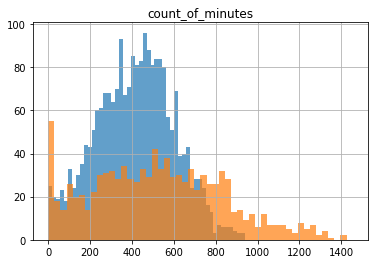

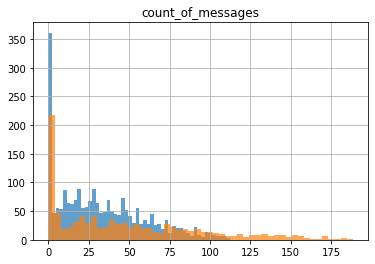

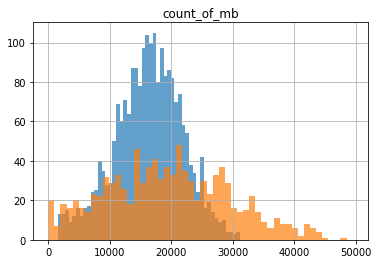

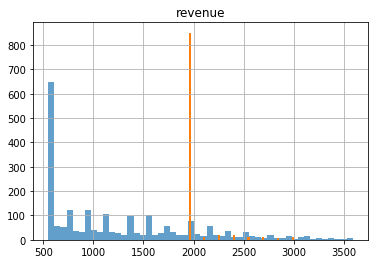

In [34]:
hist_of_data_2(pivot_data
               .query('tariff == "smart"')
               .loc[:,['count_of_minutes'
                       , 'count_of_messages'
                       , 'count_of_mb'
                       , 'revenue']]
              ,pivot_data
               .query('tariff == "ultra"')
               .loc[:,['count_of_minutes'
                       , 'count_of_messages'
                       , 'count_of_mb'
                       , 'revenue']])

В случае метрик `count_of_minutes` и `count_of_mb` мы имеем дело с нормальным распределением. Для тарифа `ultra`гистограмма более пологая, что говорит нам о достаточно равномерном распределении пользователей относительно используемого трафика, хотя казалось бы, пользователи такого тарифа, как `ultra` должны потреблять больше предоставляемых услуг, по крайней мере, исходя из условий самого тарифа.

Для тарифа `smart` ситуация несколько иная. Здесь пик распределения сформирован достаточно наглядно для визуальной оценки потребляемого количества минут и мегабайт освновной массой пользователей этого тарифа.

Метрика `count_of_messages` является дискретной величиной завязанной на единицу времени (в нашем случае это месяц). Следовательно перед нами распределение Пуассона. Стоит заметить, что снова распределение для тарифа `ultra` носит более пологий характер, при этом, как и в случае тарифа `smart`, большинстов пользователей отправляет до 100 сообщений в месяц. 

Что касается выручки, метрика `revenue`, не уверен, что можно было бы считать построенные гистограммы распределением Пуассона, но из любопытного нельзя не отметить, что большое количество пользователей обоих тарифов приносит компании прибыль в первую очередь именно за счёт абоненсткой платы (особенно бескомпромиссно это выглядит для тарифа `ultra`), о чём и свидетельствуют характерные частотные пики, относящиеся к размеру абонентской платы каждого из тарифов. 

### Шаг 4. Проверка гипотезы. <a id="Step_4"></a>

*4.1. Проверим гипотезу о том, что средняя выручка пользователей тарифов «Ультра» и «Смарт» различается.* <a id="Step_4_1"></a>

За нулевую гипотезу `Н_0` примем, что средняя выручка пользователей тарифов «Ультра» и «Смарт» равна.

За альтернативную гипотезу `Н_1` примем обратное утверждение.

Установим уровень критической значимости как `alpha = .05`

Чтобы понять, какое значение присвоить параметру `equal_var`, произведём оценку дисперсии для каждой выборки.

In [35]:
print(int(pivot_data.query('tariff == "smart"')['revenue'].var()))
print(int(pivot_data.query('tariff == "ultra"')['revenue'].var()))

695214
148563


Так как дисперсии первой и второй выборки достаточно сильно отличаются, параметру `equal_var` присвоим значение False. Получив все необходимые параметры, перейдём к проверке гипотезы через T-критерий Стьюдента.

In [36]:
alpha = 0.05

results =  st.ttest_ind(
    pivot_data.query('tariff == "smart"')['revenue'], 
    pivot_data.query('tariff == "ultra"')['revenue'],
    equal_var = False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 3.63052752503124e-235
Отвергаем нулевую гипотезу


Исходя из результата статистического теста о равенстве средних двух генеральных совокупностей, на основании данных выборки по тарифам `smart` и `ultra`, можно сделать вывод о том, что средние показатели выручки двух тарифов действительно различаются. 

*4.2. Проверим гипотезу о том, что средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.* <a id="Step_4_2"></a>

Сначала добавим в нашу сводную таблицу `pivot_data` города пользователей.

In [37]:
pivot_data = pivot_data.merge(data_users.loc[:,['user_id','city']]
                                                , how='left'
                                                , on=['user_id'])

За нулевую гипотезу `Н_0` примем, что средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов.

За альтернативную гипотезу `Н_1` примем обратное утверждение.

Установим уровень критической значимости как `alpha = .05`

Как в предыдущем случае произведём оценку дисперсии каждой выборки, для определения значения параметра `equal_var`.

In [38]:
print(int(pivot_data.query('city == "Москва"')['revenue'].var()))
print(int(pivot_data.query('city != "Москва"')['revenue'].var()))

573097
671746


Разница между дисперсиями уже не так велика как при проверке предыдущей гипотезы, и, следовательно, в этот раз примем `equal_var` равным True. Проведём проверку гипотезы через T-критерий Стьюдента.

In [39]:
alpha = 0.05

results =  st.ttest_ind(
    pivot_data.query('city == "Москва"')['revenue'], 
    pivot_data.query('city != "Москва"')['revenue'],
    equal_var = True)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.5839558505513711
Не получилось отвергнуть нулевую гипотезу


В итоге получаем ситуацию прямо противоположную результатам предыдущей задачи. Статистический тест показывает, что среднее генеральных совокупностей выручки Москвы и других регионов не отличаются друг от друга. 

### Шаг 5. Общий вывод. <a id="Step_5"></a>

Итак. Из всего вышесказанного, посчитанного и построенного можно сделать однозначный вывод, что абсолютным лидером из предложенных для анализа тарифов является `smart`. Динамика, выручка, число клиентов - всё на его стороне. 

Хотя и альтернативный вариант, `ultra`, судя по тем же метрикам и графикам, для компании, в целом, тоже очень даже неплох. В силу условий тарифа, удельная прибыль с одного клиента тут явно выше, а потребление предоставляемого трафика, в свою очередь, статистически не сильно выходит в основной массе своей за пределы аналогиного уровная для клиентов тарифа `smart`.

Так что и за этих ребят тоже стоит побороться, с оговоркой, конечно же, что деньги стоит вкладывать в первую очередь в то, что работает и работает хорошо, а в нашем случае тариф `smart`, в этом плане, безусловный лидер.